# Unit07_Isolation_Forest | 孤立森林異常檢測

本 Notebook 使用模擬的化工反應器操作數據建立孤立森林 (Isolation Forest) 模型來檢測異常操作條件。

## 目標
- 理解孤立森林演算法的核心原理與實作流程
- 學習使用 scikit-learn 建立與訓練孤立森林模型
- 掌握異常檢測模型的評估方法（精確率、召回率、F1、AUC）
- 應用孤立森林於化工反應器異常監控
- 視覺化與解釋異常檢測結果

---
## 0. 環境設定

In [15]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit07_Isolation_Forest'
SOURCE_DATA_DIR = 'reactor_operation'

try:
    from google.colab import drive
    IN_COLAB = True
    print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
    drive.mount('/content/drive', force_remount=True)
except ImportError:
    IN_COLAB = False
    print("✓ 偵測到 Local 環境")

try:
    shortcut_path = '/content/CHE-AI-COURSE'
    os.remove(shortcut_path)
except FileNotFoundError:
    pass

if IN_COLAB:
    source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
    os.symlink(source_path, shortcut_path)
    shortcut_path = Path(shortcut_path)
    if source_path.exists():
        NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit07'
        OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
        DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
        MODEL_DIR = OUTPUT_DIR / 'models'
        FIG_DIR = OUTPUT_DIR / 'figs'
    else:
        print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
else:
    NOTEBOOK_DIR = Path.cwd()
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\data\reactor_operation
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_Isolation_Forest
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_Isolation_Forest\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_Isolation_Forest\figs


In [16]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# sklearn 套件
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve,
    average_precision_score
)

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(SEED)

# 設定 matplotlib 參數
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

print("✓ 套件載入完成")

✓ 套件載入完成


---
## 1. 生成模擬數據：反應器操作數據

我們將模擬一個化工連續攪拌槽反應器 (CSTR) 的操作數據，包含：
- **正常操作數據**（95%）：反應器在穩定操作條件下的數據
- **異常操作數據**（5%）：包含多種異常情境
  - **溫度失控**：溫度急劇升高
  - **壓力異常**：壓力異常波動
  - **流量異常**：進料或冷卻流量異常
  - **攪拌故障**：攪拌速度異常
  - **產物濃度異常**：產物濃度異常偏離

**監控變數**：
- Temperature (°C)：反應器溫度
- Pressure (bar)：反應器壓力
- Feed_Flow (m³/h)：進料流量
- Cooling_Flow (m³/h)：冷卻水流量
- Stirring_Speed (rpm)：攪拌速度
- Product_Conc (mol/L)：產物濃度

In [17]:
# 設定隨機種子
np.random.seed(SEED)

# 生成正常操作數據 (95%)
n_normal = 1900
n_anomaly = 100  # 5% 異常

# 正常操作數據（穩定操作條件）- 增加變異性
normal_data = {
    'Temperature': np.random.normal(350, 8, n_normal),      # 增加標準差 5→8
    'Pressure': np.random.normal(8.0, 0.5, n_normal),       # 增加標準差 0.3→0.5
    'Feed_Flow': np.random.normal(35, 3, n_normal),         # 增加標準差 2→3
    'Cooling_Flow': np.random.normal(20, 2, n_normal),      # 增加標準差 1.5→2
    'Stirring_Speed': np.random.normal(300, 20, n_normal),  # 增加標準差 15→20
    'Product_Conc': np.random.normal(0.75, 0.08, n_normal), # 增加標準差 0.05→0.08
}

# 生成異常操作數據 (5%) - 降低異常程度，增加挑戰性
# 異常類型 1: 溫度失控 (20 樣本) - 調整為更輕微的異常
temp_runaway = {
    'Temperature': np.random.normal(375, 8, 20),            # 降低異常程度 395→375
    'Pressure': np.random.normal(8.8, 0.6, 20),             # 降低異常程度 9.5→8.8
    'Feed_Flow': np.random.normal(35, 3, 20),
    'Cooling_Flow': np.random.normal(23, 2, 20),            # 降低異常程度 25→23
    'Stirring_Speed': np.random.normal(300, 20, 20),
    'Product_Conc': np.random.normal(0.70, 0.08, 20),       # 降低異常程度 0.65→0.70
}

# 異常類型 2: 壓力異常 (20 樣本) - 調整為更輕微的異常
pressure_anomaly = {
    'Temperature': np.random.normal(350, 8, 20),
    'Pressure': np.random.normal(9.2, 0.7, 20),             # 降低異常程度 10.5→9.2
    'Feed_Flow': np.random.normal(38, 3, 20),               # 降低異常程度 40→38
    'Cooling_Flow': np.random.normal(20, 2, 20),
    'Stirring_Speed': np.random.normal(300, 20, 20),
    'Product_Conc': np.random.normal(0.75, 0.08, 20),
}

# 異常類型 3: 冷卻流量異常 (20 樣本) - 調整為更輕微的異常
cooling_anomaly = {
    'Temperature': np.random.normal(362, 8, 20),            # 降低異常程度 370→362
    'Pressure': np.random.normal(8.3, 0.5, 20),             # 降低異常程度 8.5→8.3
    'Feed_Flow': np.random.normal(35, 3, 20),
    'Cooling_Flow': np.random.normal(15, 2, 20),            # 降低異常程度 10→15
    'Stirring_Speed': np.random.normal(300, 20, 20),
    'Product_Conc': np.random.normal(0.72, 0.08, 20),       # 降低異常程度 0.70→0.72
}

# 異常類型 4: 攪拌故障 (20 樣本) - 調整為更輕微的異常
stirring_fault = {
    'Temperature': np.random.normal(355, 8, 20),
    'Pressure': np.random.normal(8.0, 0.5, 20),
    'Feed_Flow': np.random.normal(35, 3, 20),
    'Cooling_Flow': np.random.normal(20, 2, 20),
    'Stirring_Speed': np.random.normal(220, 25, 20),        # 降低異常程度 150→220
    'Product_Conc': np.random.normal(0.70, 0.08, 20),       # 降低異常程度 0.65→0.70
}

# 異常類型 5: 產物濃度異常 (20 樣本) - 調整為更輕微的異常
product_anomaly = {
    'Temperature': np.random.normal(350, 8, 20),
    'Pressure': np.random.normal(8.0, 0.5, 20),
    'Feed_Flow': np.random.normal(32, 3, 20),               # 降低異常程度 30→32
    'Cooling_Flow': np.random.normal(20, 2, 20),
    'Stirring_Speed': np.random.normal(300, 20, 20),
    'Product_Conc': np.random.normal(0.60, 0.08, 20),       # 降低異常程度 0.50→0.60
}

# 合併所有數據
all_data = []
labels = []

# 添加正常數據
for i in range(n_normal):
    sample = [
        normal_data['Temperature'][i],
        normal_data['Pressure'][i],
        normal_data['Feed_Flow'][i],
        normal_data['Cooling_Flow'][i],
        normal_data['Stirring_Speed'][i],
        normal_data['Product_Conc'][i]
    ]
    all_data.append(sample)
    labels.append(0)  # 0 代表正常

# 添加異常數據
for anomaly_dict in [temp_runaway, pressure_anomaly, cooling_anomaly, 
                     stirring_fault, product_anomaly]:
    for i in range(20):
        sample = [
            anomaly_dict['Temperature'][i],
            anomaly_dict['Pressure'][i],
            anomaly_dict['Feed_Flow'][i],
            anomaly_dict['Cooling_Flow'][i],
            anomaly_dict['Stirring_Speed'][i],
            anomaly_dict['Product_Conc'][i]
        ]
        all_data.append(sample)
        labels.append(1)  # 1 代表異常

# 轉換為 NumPy 陣列
X = np.array(all_data)
y = np.array(labels)

# 建立 DataFrame
feature_names = ['Temperature', 'Pressure', 'Feed_Flow', 
                'Cooling_Flow', 'Stirring_Speed', 'Product_Conc']
df = pd.DataFrame(X, columns=feature_names)
df['Anomaly'] = y

# 顯示數據資訊
print("=== 數據集資訊 ===")
print(f"總樣本數: {len(df)}")
print(f"正常樣本數: {np.sum(y == 0)} ({np.sum(y == 0)/len(df)*100:.1f}%)")
print(f"異常樣本數: {np.sum(y == 1)} ({np.sum(y == 1)/len(df)*100:.1f}%)")
print(f"\n特徵數量: {X.shape[1]}")
print(f"特徵名稱: {feature_names}")

# 顯示數據統計比較
print("\n=== 正常 vs 異常數據統計比較 ===")
comparison = pd.DataFrame({
    'Normal_Mean': df[df['Anomaly'] == 0][feature_names].mean(),
    'Normal_Std': df[df['Anomaly'] == 0][feature_names].std(),
    'Anomaly_Mean': df[df['Anomaly'] == 1][feature_names].mean(),
    'Anomaly_Std': df[df['Anomaly'] == 1][feature_names].std(),
})
comparison['Difference'] = abs(comparison['Normal_Mean'] - comparison['Anomaly_Mean'])
print(comparison)

# 顯示前幾筆數據
print("\n=== 數據預覽 ===")
print(df.head(10))

=== 數據集資訊 ===
總樣本數: 2000
正常樣本數: 1900 (95.0%)
異常樣本數: 100 (5.0%)

特徵數量: 6
特徵名稱: ['Temperature', 'Pressure', 'Feed_Flow', 'Cooling_Flow', 'Stirring_Speed', 'Product_Conc']

=== 正常 vs 異常數據統計比較 ===
                Normal_Mean  Normal_Std  Anomaly_Mean  Anomaly_Std  Difference
Temperature      350.343177    7.883765    358.053027    12.440361    7.709849
Pressure           8.002103    0.503504      8.366781     0.805674    0.364677
Feed_Flow         34.878826    2.971454     35.168295     3.402526    0.289469
Cooling_Flow      19.932250    2.078189     19.764330     3.259762    0.167920
Stirring_Speed   300.409219   20.019159    280.852763    38.760866   19.556456
Product_Conc       0.747914    0.077710      0.705167     0.104987    0.042747

=== 數據預覽 ===
   Temperature  Pressure  Feed_Flow  Cooling_Flow  Stirring_Speed  \
0   353.973713  8.348477  30.834372     19.949012      297.422452   
1   348.893886  7.833090  30.199187     19.565682      289.818124   
2   355.181508  8.586562  31.3481

### 1.1 探索性數據分析 (EDA)

=== 統計摘要 ===
Anomaly                         0           1
Temperature    count  1900.000000  100.000000
               mean    350.343177  358.053027
               std       7.883765   12.440361
               min     324.069861  326.730714
               25%     345.013619  347.959658
               50%     350.293068  357.125327
               75%     355.455255  368.015196
               max     380.821852  387.241485
Pressure       count  1900.000000  100.000000
               mean      8.002103    8.366781
               std       0.503504    0.805674
               min       6.490244    6.807331
               25%       7.660335    7.772388
               50%       8.003466    8.295515
               75%       8.334588    8.824367
               max       9.963119   10.216349
Feed_Flow      count  1900.000000  100.000000
               mean     34.878826   35.168295
               std       2.971454    3.402526
               min      25.469889   26.600107
               25%   

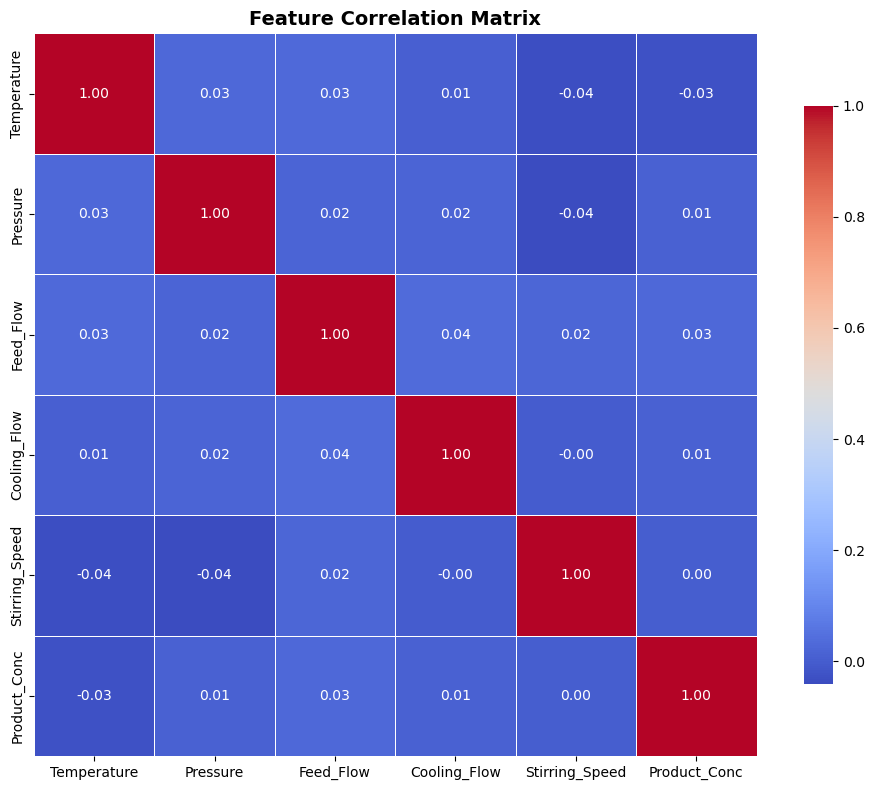


✓ 相關性熱圖已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_Isolation_Forest\figs\correlation_matrix.png


In [18]:
# 統計摘要
print("=== 統計摘要 ===")
print(df.groupby('Anomaly')[feature_names].describe().T)

# 相關性矩陣
print("\n=== 特徵相關性矩陣 ===")
correlation_matrix = df[feature_names].corr()
print(correlation_matrix)

# 繪製相關性熱圖
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 相關性熱圖已儲存至:", FIG_DIR / 'correlation_matrix.png')

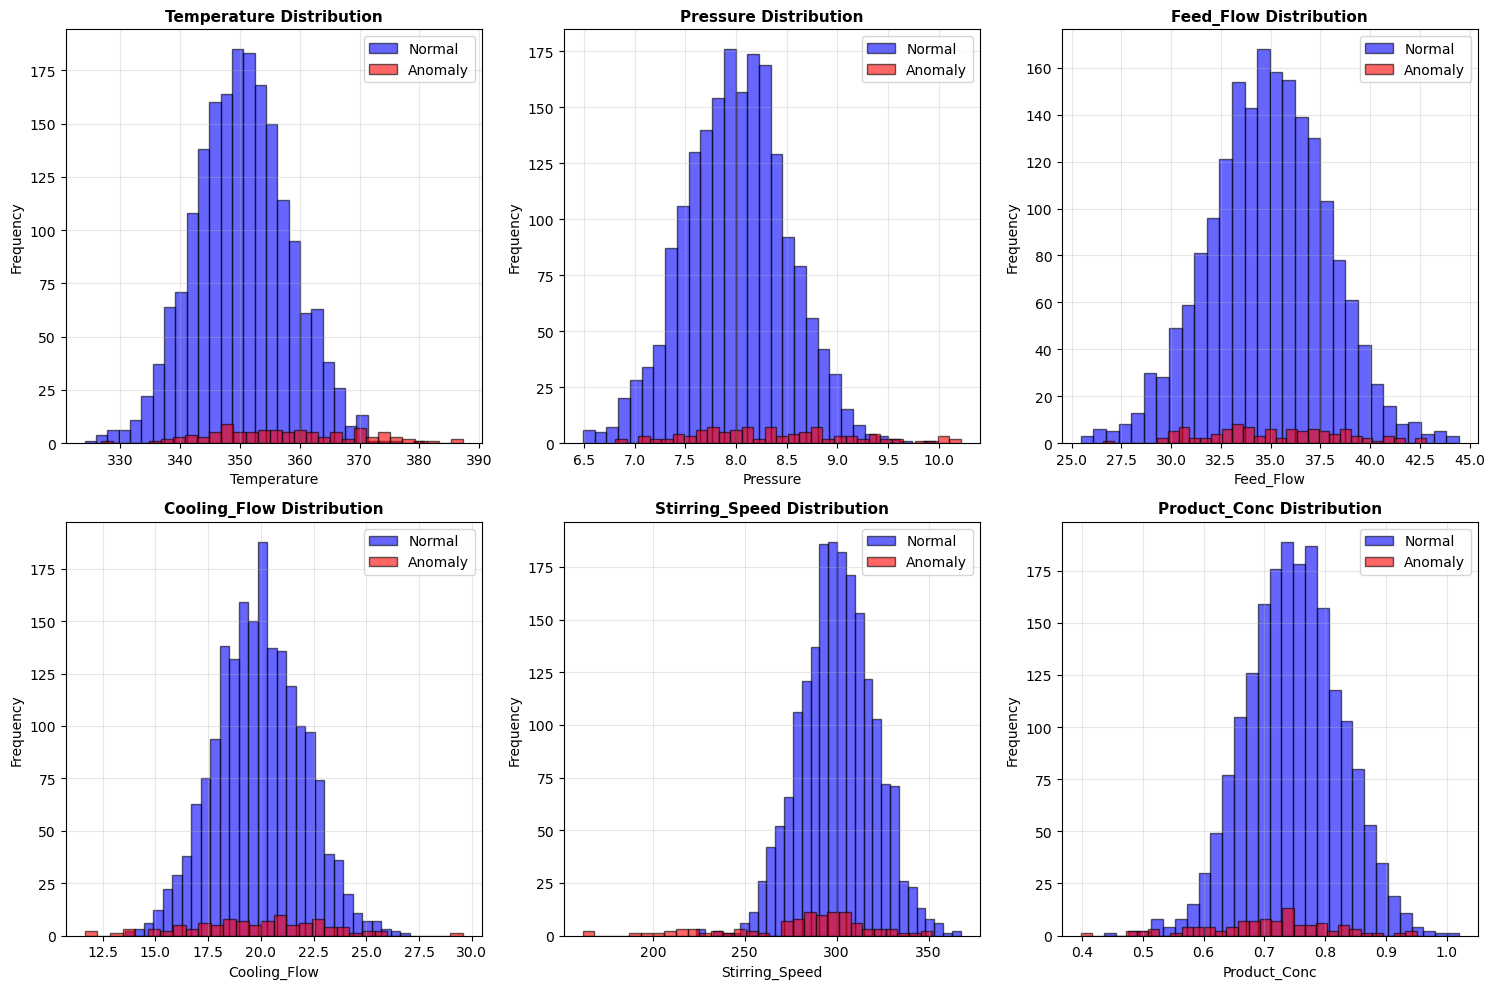


✓ 特徵分布圖已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_Isolation_Forest\figs\feature_distributions.png


In [19]:
# 繪製特徵分布圖（正常 vs 異常）
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(feature_names):
    ax = axes[idx]
    
    # 正常數據
    normal_values = df[df['Anomaly'] == 0][feature]
    # 異常數據
    anomaly_values = df[df['Anomaly'] == 1][feature]
    
    # 繪製直方圖
    ax.hist(normal_values, bins=30, alpha=0.6, label='Normal', color='blue', edgecolor='black')
    ax.hist(anomaly_values, bins=30, alpha=0.6, label='Anomaly', color='red', edgecolor='black')
    
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'{feature} Distribution', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 特徵分布圖已儲存至:", FIG_DIR / 'feature_distributions.png')

---
## 2. 數據前處理

In [20]:
# 分割訓練集與測試集
# 注意：孤立森林是非監督學習，訓練時不使用標籤
# 但為了評估模型性能，我們保留真實標籤用於測試
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

print("=== 數據分割 ===")
print(f"訓練集大小: {X_train.shape[0]} 樣本")
print(f"  正常: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  異常: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"\n測試集大小: {X_test.shape[0]} 樣本")
print(f"  正常: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  異常: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")

# 孤立森林對特徵尺度不敏感，但我們仍展示標準化的選項
# 實際使用時可以不標準化
print("\n=== 特徵標準化（選擇性） ===")
print("註：孤立森林對特徵尺度不敏感，此步驟為示範用途")
print("實務上可直接使用原始數據")

=== 數據分割 ===
訓練集大小: 1400 樣本
  正常: 1330 (95.0%)
  異常: 70 (5.0%)

測試集大小: 600 樣本
  正常: 570 (95.0%)
  異常: 30 (5.0%)

=== 特徵標準化（選擇性） ===
註：孤立森林對特徵尺度不敏感，此步驟為示範用途
實務上可直接使用原始數據


---
## 3. 建立與訓練孤立森林模型

### 3.1 建立孤立森林模型

**關鍵超參數設定**：
- `n_estimators=100`：使用 100 棵孤立樹
- `contamination=0.05`：預期 5% 的數據為異常（與真實異常率相同）
- `max_samples='auto'`：自動設為 min(256, n_samples)
- `random_state=42`：設定隨機種子以確保可重現性
- `n_jobs=-1`：使用所有 CPU 核心加速訓練

In [21]:
# 建立孤立森林模型
iso_forest = IsolationForest(
    n_estimators=100,           # 使用 100 棵樹
    max_samples='auto',         # 每棵樹使用 256 個樣本
    contamination=0.05,         # 預期 5% 的數據為異常
    random_state=SEED,          # 設定隨機種子
    n_jobs=-1,                  # 使用所有 CPU 核心
    verbose=0                   # 不顯示訓練過程
)

print("=== 孤立森林模型參數 ===")
print(f"樹的數量 (n_estimators): {iso_forest.n_estimators}")
print(f"子樣本大小 (max_samples): {iso_forest.max_samples}")
print(f"異常比例 (contamination): {iso_forest.contamination}")
print(f"隨機種子 (random_state): {iso_forest.random_state}")
print(f"並行運算 (n_jobs): {iso_forest.n_jobs}")

=== 孤立森林模型參數 ===
樹的數量 (n_estimators): 100
子樣本大小 (max_samples): auto
異常比例 (contamination): 0.05
隨機種子 (random_state): 42
並行運算 (n_jobs): -1


### 3.2 訓練模型

In [22]:
import time

# 訓練模型
print("=== 開始訓練孤立森林模型 ===")
start_time = time.time()

iso_forest.fit(X_train)

training_time = time.time() - start_time
print(f"✓ 訓練完成！訓練時間: {training_time:.4f} 秒")

# 顯示模型屬性
print(f"\n=== 訓練後模型屬性 ===")
print(f"決策閾值偏移量 (offset_): {iso_forest.offset_:.4f}")
print(f"訓練特徵數量 (n_features_in_): {iso_forest.n_features_in_}")
print(f"孤立樹數量: {len(iso_forest.estimators_)}")

=== 開始訓練孤立森林模型 ===
✓ 訓練完成！訓練時間: 0.2060 秒

=== 訓練後模型屬性 ===
決策閾值偏移量 (offset_): -0.5185
訓練特徵數量 (n_features_in_): 6
孤立樹數量: 100


---
## 4. 異常檢測與評估

### 4.1 預測異常標籤與計算異常分數

In [23]:
# 預測測試集
y_pred = iso_forest.predict(X_test)  # 1: 正常, -1: 異常
y_pred_binary = (y_pred == -1).astype(int)  # 轉換為 0: 正常, 1: 異常

# 計算異常分數
anomaly_scores = iso_forest.score_samples(X_test)  # 分數越低越異常
decision_scores = iso_forest.decision_function(X_test)  # 負值表示異常

print("=== 預測結果 ===")
print(f"測試集樣本數: {len(y_test)}")
print(f"預測為正常: {np.sum(y_pred == 1)} 樣本")
print(f"預測為異常: {np.sum(y_pred == -1)} 樣本")
print(f"異常比例: {np.sum(y_pred == -1)/len(y_pred)*100:.2f}%")

print(f"\n=== 異常分數統計 ===")
print(f"異常分數範圍: [{anomaly_scores.min():.4f}, {anomaly_scores.max():.4f}]")
print(f"異常分數平均: {anomaly_scores.mean():.4f}")
print(f"異常分數標準差: {anomaly_scores.std():.4f}")
print(f"決策閾值: {iso_forest.offset_:.4f}")

=== 預測結果 ===
測試集樣本數: 600
預測為正常: 568 樣本
預測為異常: 32 樣本
異常比例: 5.33%

=== 異常分數統計 ===
異常分數範圍: [-0.6067, -0.3692]
異常分數平均: -0.4373
異常分數標準差: 0.0420
決策閾值: -0.5185


### 4.2 評估模型性能：混淆矩陣與分類報告

=== 混淆矩陣 ===
[[549  21]
 [ 19  11]]

True Negatives (TN): 549 - 正確識別為正常
False Positives (FP): 21 - 誤報為異常
False Negatives (FN): 19 - 漏報異常
True Positives (TP): 11 - 正確識別為異常


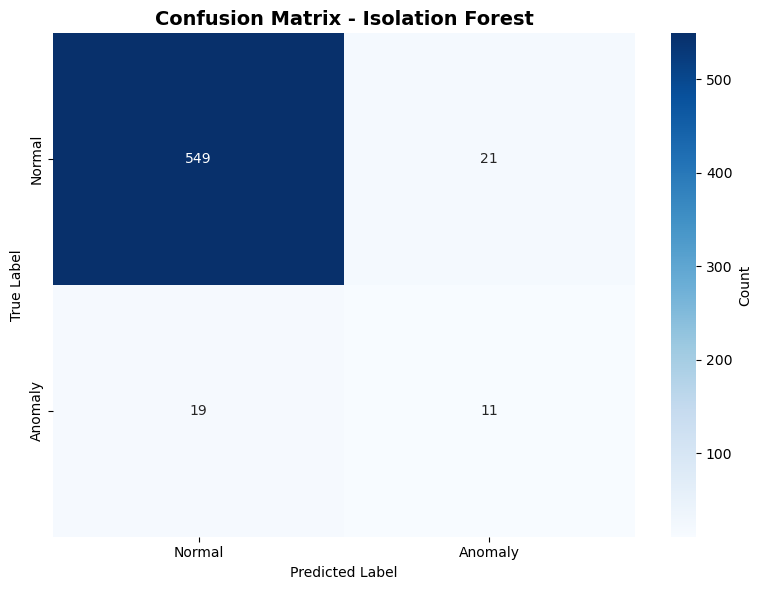


=== 分類報告 ===
              precision    recall  f1-score   support

      Normal     0.9665    0.9632    0.9649       570
     Anomaly     0.3438    0.3667    0.3548        30

    accuracy                         0.9333       600
   macro avg     0.6551    0.6649    0.6598       600
weighted avg     0.9354    0.9333    0.9344       600

=== 關鍵指標摘要 ===
Precision (精確率): 0.3438 - 告警中有多少是真正的異常
Recall (召回率): 0.3667 - 實際異常中有多少被檢測到
F1-Score: 0.3548 - 精確率與召回率的調和平均

✓ 混淆矩陣已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_Isolation_Forest\figs\confusion_matrix.png


In [24]:
# 計算混淆矩陣
cm = confusion_matrix(y_test, y_pred_binary)

print("=== 混淆矩陣 ===")
print(cm)
print(f"\nTrue Negatives (TN): {cm[0, 0]} - 正確識別為正常")
print(f"False Positives (FP): {cm[0, 1]} - 誤報為異常")
print(f"False Negatives (FN): {cm[1, 0]} - 漏報異常")
print(f"True Positives (TP): {cm[1, 1]} - 正確識別為異常")

# 視覺化混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            cbar_kws={'label': 'Count'})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Isolation Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 分類報告
print("\n=== 分類報告 ===")
print(classification_report(y_test, y_pred_binary, 
                          target_names=['Normal', 'Anomaly'],
                          digits=4))

# 計算關鍵指標
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("=== 關鍵指標摘要 ===")
print(f"Precision (精確率): {precision:.4f} - 告警中有多少是真正的異常")
print(f"Recall (召回率): {recall:.4f} - 實際異常中有多少被檢測到")
print(f"F1-Score: {f1:.4f} - 精確率與召回率的調和平均")

print("\n✓ 混淆矩陣已儲存至:", FIG_DIR / 'confusion_matrix.png')

### 4.3 ROC 曲線與 AUC

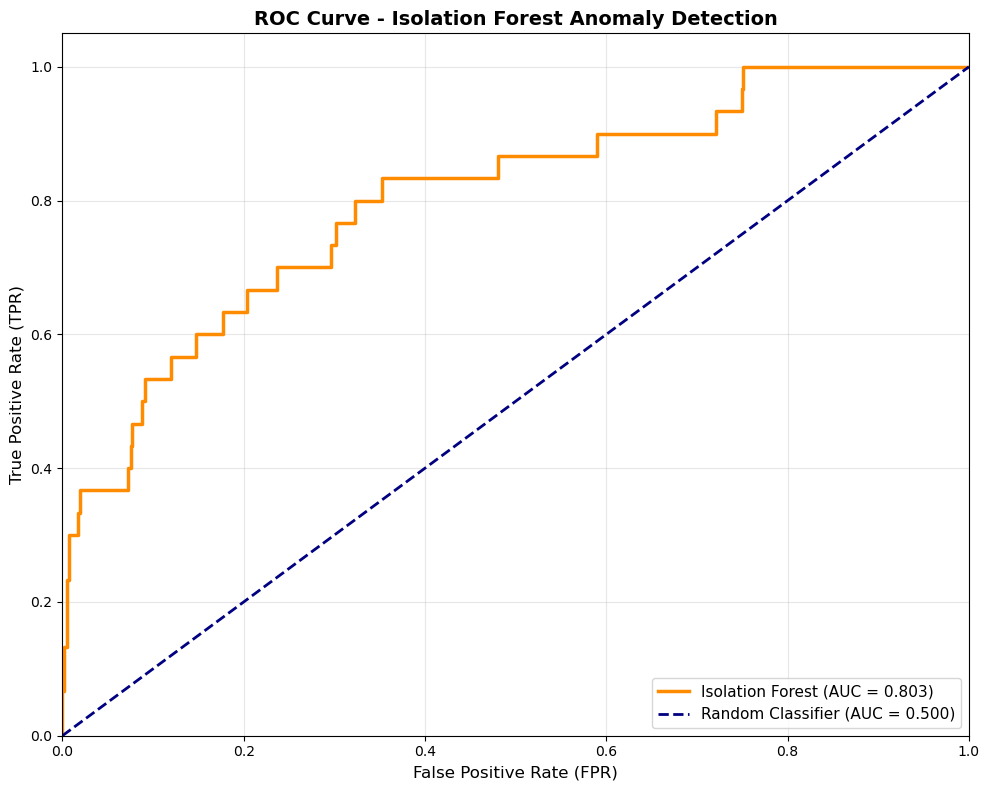

=== ROC-AUC 評估 ===
AUC-ROC: 0.8026
評價：良好 (Good)

✓ ROC 曲線已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_Isolation_Forest\figs\roc_curve.png


In [25]:
# 計算 ROC 曲線（使用異常分數的負值，使異常點分數更高）
anomaly_scores_positive = -anomaly_scores
fpr, tpr, thresholds = roc_curve(y_test, anomaly_scores_positive)
roc_auc = auc(fpr, tpr)

# 繪製 ROC 曲線
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2.5, 
         label=f'Isolation Forest (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve - Isolation Forest Anomaly Detection', 
          fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"=== ROC-AUC 評估 ===")
print(f"AUC-ROC: {roc_auc:.4f}")
if roc_auc > 0.9:
    print("評價：優秀 (Excellent)")
elif roc_auc > 0.8:
    print("評價：良好 (Good)")
elif roc_auc > 0.7:
    print("評價：尚可 (Fair)")
else:
    print("評價：需改進 (Needs Improvement)")

print("\n✓ ROC 曲線已儲存至:", FIG_DIR / 'roc_curve.png')

---
## 5. 結果視覺化與分析

### 5.1 異常分數分布

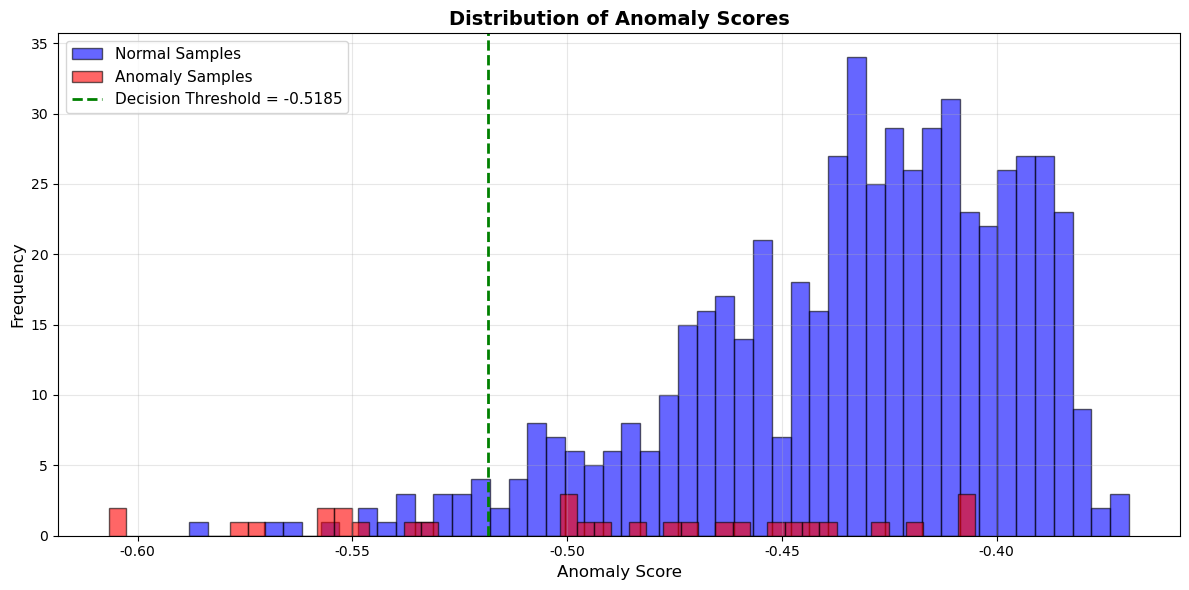

=== 異常分數統計（按真實標籤） ===
正常樣本異常分數: Mean = -0.4342, Std = 0.0386
異常樣本異常分數: Mean = -0.4962, Std = 0.0590
分數差異: 0.0620

✓ 異常分數分布圖已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_Isolation_Forest\figs\anomaly_score_distribution.png


In [26]:
# 繪製異常分數分布（分正常與異常）
plt.figure(figsize=(12, 6))

# 正常樣本的異常分數
normal_scores = anomaly_scores[y_test == 0]
# 異常樣本的異常分數
anomaly_scores_true = anomaly_scores[y_test == 1]

plt.hist(normal_scores, bins=50, alpha=0.6, label='Normal Samples', 
         color='blue', edgecolor='black')
plt.hist(anomaly_scores_true, bins=50, alpha=0.6, label='Anomaly Samples', 
         color='red', edgecolor='black')
plt.axvline(x=iso_forest.offset_, color='green', linestyle='--', linewidth=2,
            label=f'Decision Threshold = {iso_forest.offset_:.4f}')
plt.xlabel('Anomaly Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Anomaly Scores', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'anomaly_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("=== 異常分數統計（按真實標籤） ===")
print(f"正常樣本異常分數: Mean = {normal_scores.mean():.4f}, Std = {normal_scores.std():.4f}")
print(f"異常樣本異常分數: Mean = {anomaly_scores_true.mean():.4f}, Std = {anomaly_scores_true.std():.4f}")
print(f"分數差異: {abs(normal_scores.mean() - anomaly_scores_true.mean()):.4f}")

print("\n✓ 異常分數分布圖已儲存至:", FIG_DIR / 'anomaly_score_distribution.png')

### 5.2 PCA 投影視覺化

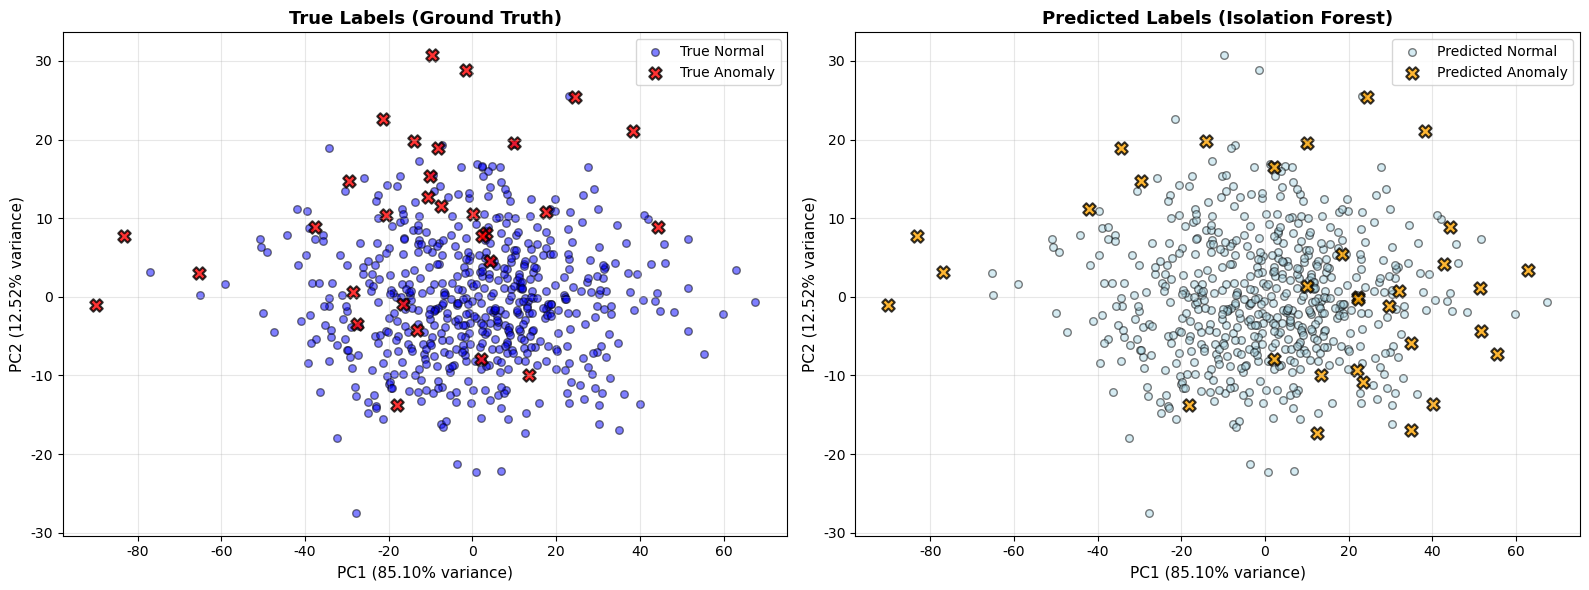

=== PCA 解釋變異數 ===
PC1: 85.10%
PC2: 12.52%
累積解釋變異數: 97.62%

✓ PCA 視覺化已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_Isolation_Forest\figs\pca_visualization.png


In [27]:
# 使用 PCA 將數據降維至 2D 以便視覺化
pca = PCA(n_components=2, random_state=SEED)
X_test_pca = pca.fit_transform(X_test)

# 繪製 PCA 投影（顯示真實標籤與預測結果）
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左圖：真實標籤
ax1 = axes[0]
scatter1 = ax1.scatter(X_test_pca[y_test == 0, 0], X_test_pca[y_test == 0, 1],
                       c='blue', label='True Normal', alpha=0.5, s=30, edgecolors='k')
scatter2 = ax1.scatter(X_test_pca[y_test == 1, 0], X_test_pca[y_test == 1, 1],
                       c='red', label='True Anomaly', alpha=0.8, s=80, 
                       marker='X', edgecolors='k', linewidths=1.5)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=11)
ax1.set_title('True Labels (Ground Truth)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# 右圖：預測結果
ax2 = axes[1]
scatter3 = ax2.scatter(X_test_pca[y_pred == 1, 0], X_test_pca[y_pred == 1, 1],
                       c='lightblue', label='Predicted Normal', alpha=0.5, s=30, edgecolors='k')
scatter4 = ax2.scatter(X_test_pca[y_pred == -1, 0], X_test_pca[y_pred == -1, 1],
                       c='orange', label='Predicted Anomaly', alpha=0.8, s=80, 
                       marker='X', edgecolors='k', linewidths=1.5)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=11)
ax2.set_title('Predicted Labels (Isolation Forest)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"=== PCA 解釋變異數 ===")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"累積解釋變異數: {pca.explained_variance_ratio_.sum():.2%}")

print("\n✓ PCA 視覺化已儲存至:", FIG_DIR / 'pca_visualization.png')

---
## 6. 總結與重點回顧

### 6.1 孤立森林核心概念

通過本 Notebook 的實作，我們學習了：

1. **孤立森林的核心理念**：
   - 異常點更容易被「孤立」，需要較少的隨機分割次數
   - 基於路徑長度而非距離或密度進行異常檢測
   - 適合高維大規模數據的異常檢測

2. **關鍵超參數設定**：
   - `n_estimators`：樹的數量（通常 100-300）
   - `contamination`：預期異常比例（需根據領域知識設定）
   - `max_samples`：每棵樹的子樣本大小（預設 'auto' = min(256, n_samples)）

3. **模型評估方法**：
   - 有標籤時：精確率、召回率、F1、AUC-ROC
   - 無標籤時：視覺化、異常分數分布、領域知識驗證

4. **化工應用場景**：
   - 反應器異常監控
   - 產品品質檢測
   - 設備健康監控
   - 製程安全預警

### 6.2 實務應用建議

**化工製程異常檢測的部署策略**：

1. **數據收集階段**：
   - 收集至少 1,000 筆正常操作數據
   - 確保數據涵蓋各種正常操作條件
   - 記錄所有已知的異常事件

2. **模型訓練階段**：
   - 使用正常操作數據訓練孤立森林
   - 根據歷史異常率設定 `contamination` 參數
   - 使用交叉驗證調整超參數

3. **離線驗證階段**：
   - 使用歷史異常事件驗證模型性能
   - 分析誤報與漏報案例
   - 與製程工程師討論結果的合理性

4. **在線部署階段**：
   - 建立即時數據流處理管道
   - 實現告警系統（設定告警抑制策略）
   - 記錄所有告警事件與處置結果

5. **持續優化階段**：
   - 定期重新訓練模型（每月或每季）
   - 整合操作員反饋，調整參數
   - 監控模型性能變化

**常見陷阱與解決方案**：

| 問題 | 原因 | 解決方案 |
|------|------|----------|
| 誤報率過高 | `contamination` 設定過高 | 降低 `contamination` 值 |
| 漏報率過高 | `contamination` 設定過低 | 提高 `contamination` 值 |
| 模型不穩定 | 樹的數量不足 | 增加 `n_estimators` |
| 訓練時間過長 | 數據量過大 | 調整 `max_samples` 或使用取樣 |
| 異常分數不明顯 | 特徵選擇不當 | 進行特徵工程或特徵選擇 |

In [28]:
# 儲存訓練好的模型
import pickle

model_path = MODEL_DIR / 'isolation_forest_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(iso_forest, f)

print("=== 模型儲存 ===")
print(f"✓ 模型已儲存至: {model_path}")

# 模型性能摘要
print("\n=== 模型性能摘要 ===")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"訓練時間: {training_time:.4f} 秒")

# 所有圖檔儲存位置
print("\n=== 所有圖檔已儲存至 ===")
print(f"📁 {FIG_DIR}")
print("  - correlation_matrix.png")
print("  - feature_distributions.png")
print("  - confusion_matrix.png")
print("  - roc_curve.png")
print("  - anomaly_score_distribution.png")
print("  - pca_visualization.png")

print("\n" + "="*60)
print("🎉 Notebook 執行完成！")
print("="*60)
print("\n下一步學習：")
print("- Unit07_OneClass_SVM: 基於支持向量機的異常檢測")
print("- Unit07_LOF: 基於局部密度的異常檢測")
print("- Unit07_Elliptic_Envelope: 基於高斯分布的異常檢測")
print("- Unit07_Anomaly_Detection_Homework: 綜合練習與模型比較")

=== 模型儲存 ===
✓ 模型已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_Isolation_Forest\models\isolation_forest_model.pkl

=== 模型性能摘要 ===
Precision: 0.3438
Recall: 0.3667
F1-Score: 0.3548
AUC-ROC: 0.8026
訓練時間: 0.2060 秒

=== 所有圖檔已儲存至 ===
📁 d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_Isolation_Forest\figs
  - correlation_matrix.png
  - feature_distributions.png
  - confusion_matrix.png
  - roc_curve.png
  - anomaly_score_distribution.png
  - pca_visualization.png

🎉 Notebook 執行完成！

下一步學習：
- Unit07_OneClass_SVM: 基於支持向量機的異常檢測
- Unit07_LOF: 基於局部密度的異常檢測
- Unit07_Elliptic_Envelope: 基於高斯分布的異常檢測
- Unit07_Anomaly_Detection_Homework: 綜合練習與模型比較
